In [191]:
import statsmodels.api as sm
import pandas as pd
import numpy as np
import pmdarima as pm
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [192]:
df = pd.read_csv('..\\..\\Dataset\\testes\\dataset_casos_mensais_publicacao.csv', 
                    parse_dates=['dt_notificacao'],
                    usecols=['dt_notificacao', 'cd_municipio', 'qntd_casos', 'temp_media_mensal', 'precipitacao_total_mensal', 'vento_vlc_media_mensal']
                )
df = df.sort_values('dt_notificacao')

df_sp = df[
          (df['cd_municipio'] == 350950) 
        & (df['dt_notificacao'] >= '2018-03-01') 
        & (df['dt_notificacao'] <= '2023-12-01')

        ]

In [193]:
df_sp.set_index('dt_notificacao', inplace=True)

df_sp.fillna(method='ffill', inplace=True)

C:\Users\kenzo\AppData\Local\Temp\ipykernel_43924\1156336966.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_sp.fillna(method='ffill', inplace=True)
C:\Users\kenzo\AppData\Local\Temp\ipykernel_43924\1156336966.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sp.fillna(method='ffill', inplace=True)


In [194]:
# Split the dataset into training and testing
train_size = int(len(df_sp) * 0.7)
train = df_sp.iloc[:train_size+1]
train2 = df_sp.iloc[:train_size+2]
test = df_sp.iloc[train_size+1:]

In [195]:
y_train = train['qntd_casos']
y_test = test['qntd_casos']
y_train2 = train2['qntd_casos']
exog_train = train[['temp_media_mensal', 'precipitacao_total_mensal']]
exog_test = test[['temp_media_mensal', 'precipitacao_total_mensal']]

Estatística ADF: -4.026897272648485
p-valor: 0.0012760364147236989
ACF:
PACF:


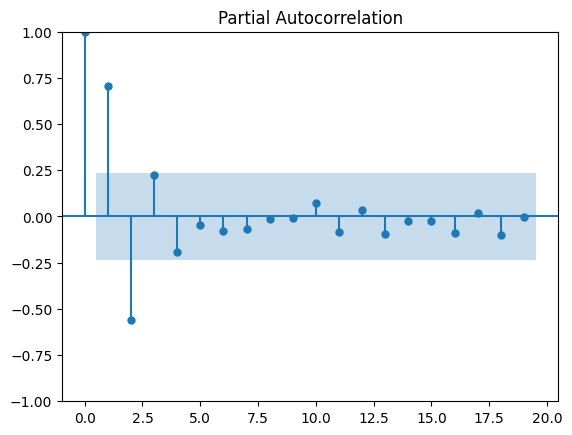

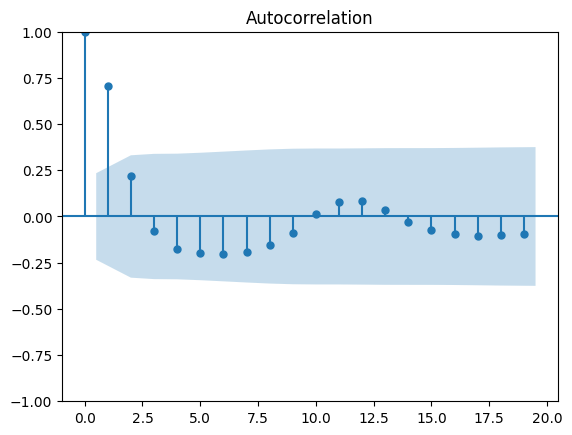

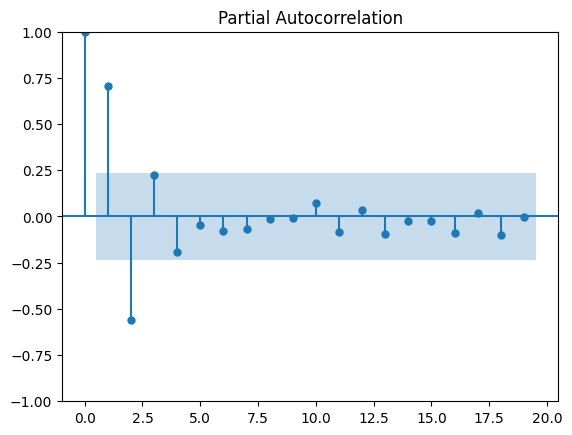

In [196]:
result = adfuller(df_sp['qntd_casos'])

print(f'Estatística ADF: {result[0]}')
print(f'p-valor: {result[1]}')
print('ACF:')
plot_acf(df_sp['qntd_casos'])
print("PACF:")
plot_pacf(df_sp['qntd_casos'])

In [197]:
model = sm.tsa.statespace.SARIMAX(
    y_train,
    exog=exog_train,
    order=(1, 1, 5), # 1, 2, 1
    seasonal_order=(1, 1, 1, 12), 
    initialization="approximate_diffuse"
)

results = model.fit()

pred = results.get_forecast(steps=len(exog_test), exog=exog_test)

y_pred_test = pred.predicted_mean

C:\Users\kenzo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\kenzo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\kenzo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\kenzo\AppData\Local\Packages\PythonSoftwareFoundati

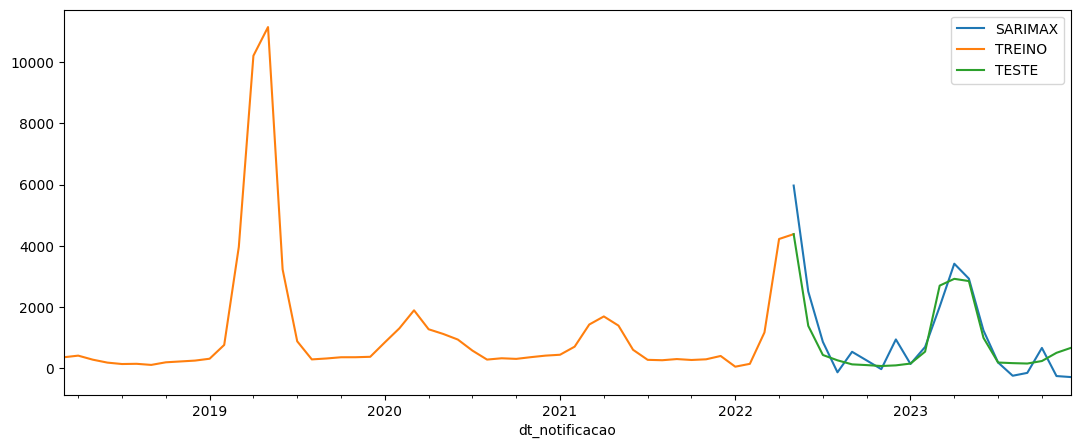

In [198]:
fig, ax = plt.subplots(figsize=(13, 5))

pred.predicted_mean.plot(ax=ax, label='SARIMAX')
y_train2.plot(ax=ax, label='TREINO')
y_test.plot(ax=ax, label='TESTE')

ax.legend()

In [199]:
MSE = mean_squared_error(y_pred=y_pred_test, y_true=y_test)
RMSE = root_mean_squared_error(y_pred=y_pred_test, y_true=y_test)
MAE = mean_absolute_error(y_pred=y_pred_test, y_true=y_test)
MAPE = mean_absolute_percentage_error(y_pred=y_pred_test, y_true=y_test)
r2 = r2_score(y_pred=y_pred_test, y_true=y_test)
print(f"MSE: {MSE}")
print(f"RMSE: {RMSE}")
print(f"MAE: {MAE}")
print(f"MAPE: {MAPE}")
print(f"r2: {r2}")

MSE: 388386.3772001564
RMSE: 623.206528528189
MAE: 478.2087085892414
MAPE: 1.4427186988348573
r2: 0.7370713713739021


In [200]:
r2

0.7370713713739021